# Lensflow

lens model mass & shear –> pretty color image showing magnification & shear:
* color = magnification
* flow lines = shear

Code by Dan Coe 2017, updated by Lukas Furtak 2025

#### Import packages

In [10]:
# Science packages
import numpy as np
from astropy.io import fits

# Import science functions
from astropy.wcs import WCS
from astropy.cosmology import FlatLambdaCDM

# Import rlic
import rlic

# Import Plotting packages
#import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from pylab import cm
#from mpl_toolkits.axes_grid1 import make_axes_locatable
quantity_support()
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For mac users with Retina display

#### Declare global variables

In [25]:
# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

# Define the cluster redshift
zd = 0.308

### Make the flow plot

#### Read the lensing maps & compute the magnification

In [26]:
# Define source redshift
zs = 6

# Define alternative lens path
altlenspath = 'JWST-based_SL-model/UNCOVER_lens-model_release/v2.0/Best-model_high-resolution_40mas/'

# Open Kappa-map
with fits.open(altlenspath+'hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_kappa.fits.gz') as hdul:
    # Read convergence
    kappa_all = hdul[0].data
    # Read WCS information
    altlenswcs = WCS(hdul[0].header)
# Open Gamma 1 map
with fits.open(altlenspath+'hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_gamma1.fits.gz') as hdul:
    # Read convergence
    gamma1_all = hdul[0].data
# Open Gamma 2 map
with fits.open(altlenspath+'hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_gamma2.fits.gz') as hdul:
    # Read convergence
    gamma2_all = hdul[0].data

# Compute distance ratio
Dds_Ds = cosmo.angular_diameter_distance_z1z2(zd, zs).to_value() / cosmo.angular_diameter_distance(zs).to_value() 

# Apply distance ratio to lens maps
kappa = Dds_Ds * kappa_all
gamma1 = Dds_Ds * gamma1_all
gamma2 = Dds_Ds * gamma2_all

# Compute magnification
mu = np.abs(1 / ((1-kappa)**2 - (gamma1**2+gamma2**2)))

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


#### Compute the x-y shear & perform the LIC

In [27]:
# Define x-y shear function
def shear2xy(g1, g2, vert=0):
    """(g1, g2) -> (e, theta) -> (ex, ey)"""
    theta = np.arctan(g2 / g1) / 2.  # CCW from x-axis
    g1pos = np.greater(g1,0)
    g2pos = np.greater(g2,0)
    thetanegg1 = np.where(g2pos, theta+np.pi/2., theta-np.pi/2.)
    theta = np.where(g1pos, theta, thetanegg1)
    theta = np.where(g1, theta, np.where(g2pos, np.pi/4., -np.pi/4.))  # / \
    # g1 + 0 - 0
    # g2 0 + 0 -
    #    - / | \  (KSB, me usually & above)
    #    | \ - /  (Bridle+, mkstarssheared.py)
    # conversion: Bridle theta = KSB theta + 90
    if vert:
        theta += np.pi/2.  # | \ - /
    g = np.hypot(g1, g2)
    e = 2 * g / (g + 1)
    ex = e * np.cos(theta)
    ey = e * np.sin(theta)
    return ex, ey

# Compute x-y shear
ex, ey = shear2xy(gamma1, gamma2)

# Define field shape
ny, nx = ey.shape

# Initiate the texture array
texture = np.random.rand(ny, nx).astype(np.float64)

# Initiate the smoothing kernel
kernellen = 31
kernel = np.sin(np.arange(kernellen)*np.pi/kernellen)
kernel = kernel.astype(np.float64)

# Perform the convolution
shear_lic = rlic.convolve(texture, ex, ey, kernel=kernel, iterations=1)

##### Have a look at the LIC before making the big plot

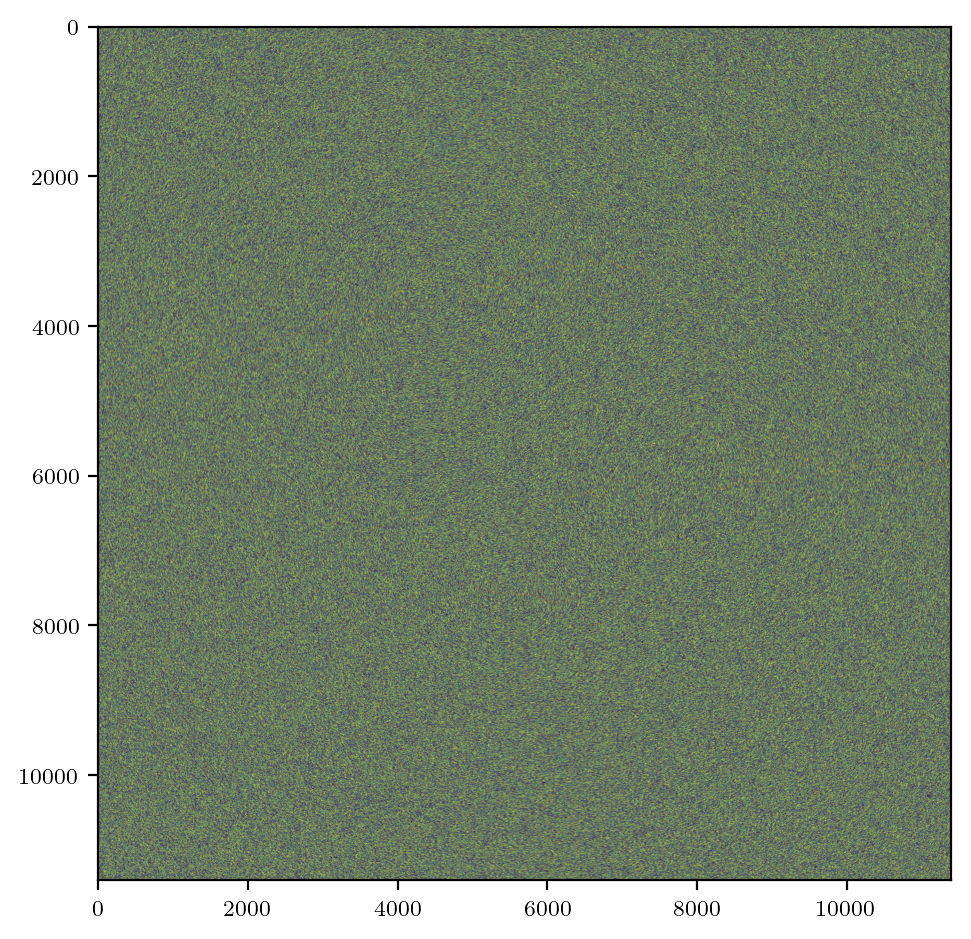

9
11


array([[0.93443958, 0.90923992, 0.94609367, ..., 0.87041563, 0.88301106,
        0.84184606],
       [1.        , 1.        , 1.        , ..., 0.99095153, 0.95354763,
        1.        ],
       [0.84038377, 1.        , 0.75108832, ..., 0.93828571, 0.96160106,
        1.        ],
       ...,
       [0.58      , 0.60693714, 0.6212988 , ..., 1.        , 0.86251789,
        0.64198794],
       [0.58      , 0.58      , 0.58      , ..., 0.58728961, 0.58      ,
        0.58      ],
       [0.58      , 0.58      , 0.58      , ..., 0.58      , 0.58      ,
        0.58      ]], shape=(11401, 11401))

In [28]:
#kfac = 1/30.
#mid = kernellen / 2.
#lo = (1-kfac) * mid
#hi = (1+kfac) * mid
#lo = 8
#hi = 12
lo = 9
hi = 11
shear_lic_p = np.clip(shear_lic, lo, hi)
shear_lic_p = (shear_lic_p - lo) / float(hi - lo)
shear_lic_p = 0.42 * shear_lic_p + 0.58
#shear_lic_p = zeropad(shear_lic_p)

plt.imshow(shear_lic_p)
plt.show()

# Print some of the parameters
print(lo)
print(hi)

#print(np.amax(shear_lic_p))
#print(np.amin(shear_lic_p))

shear_lic_p

##### Make the plot

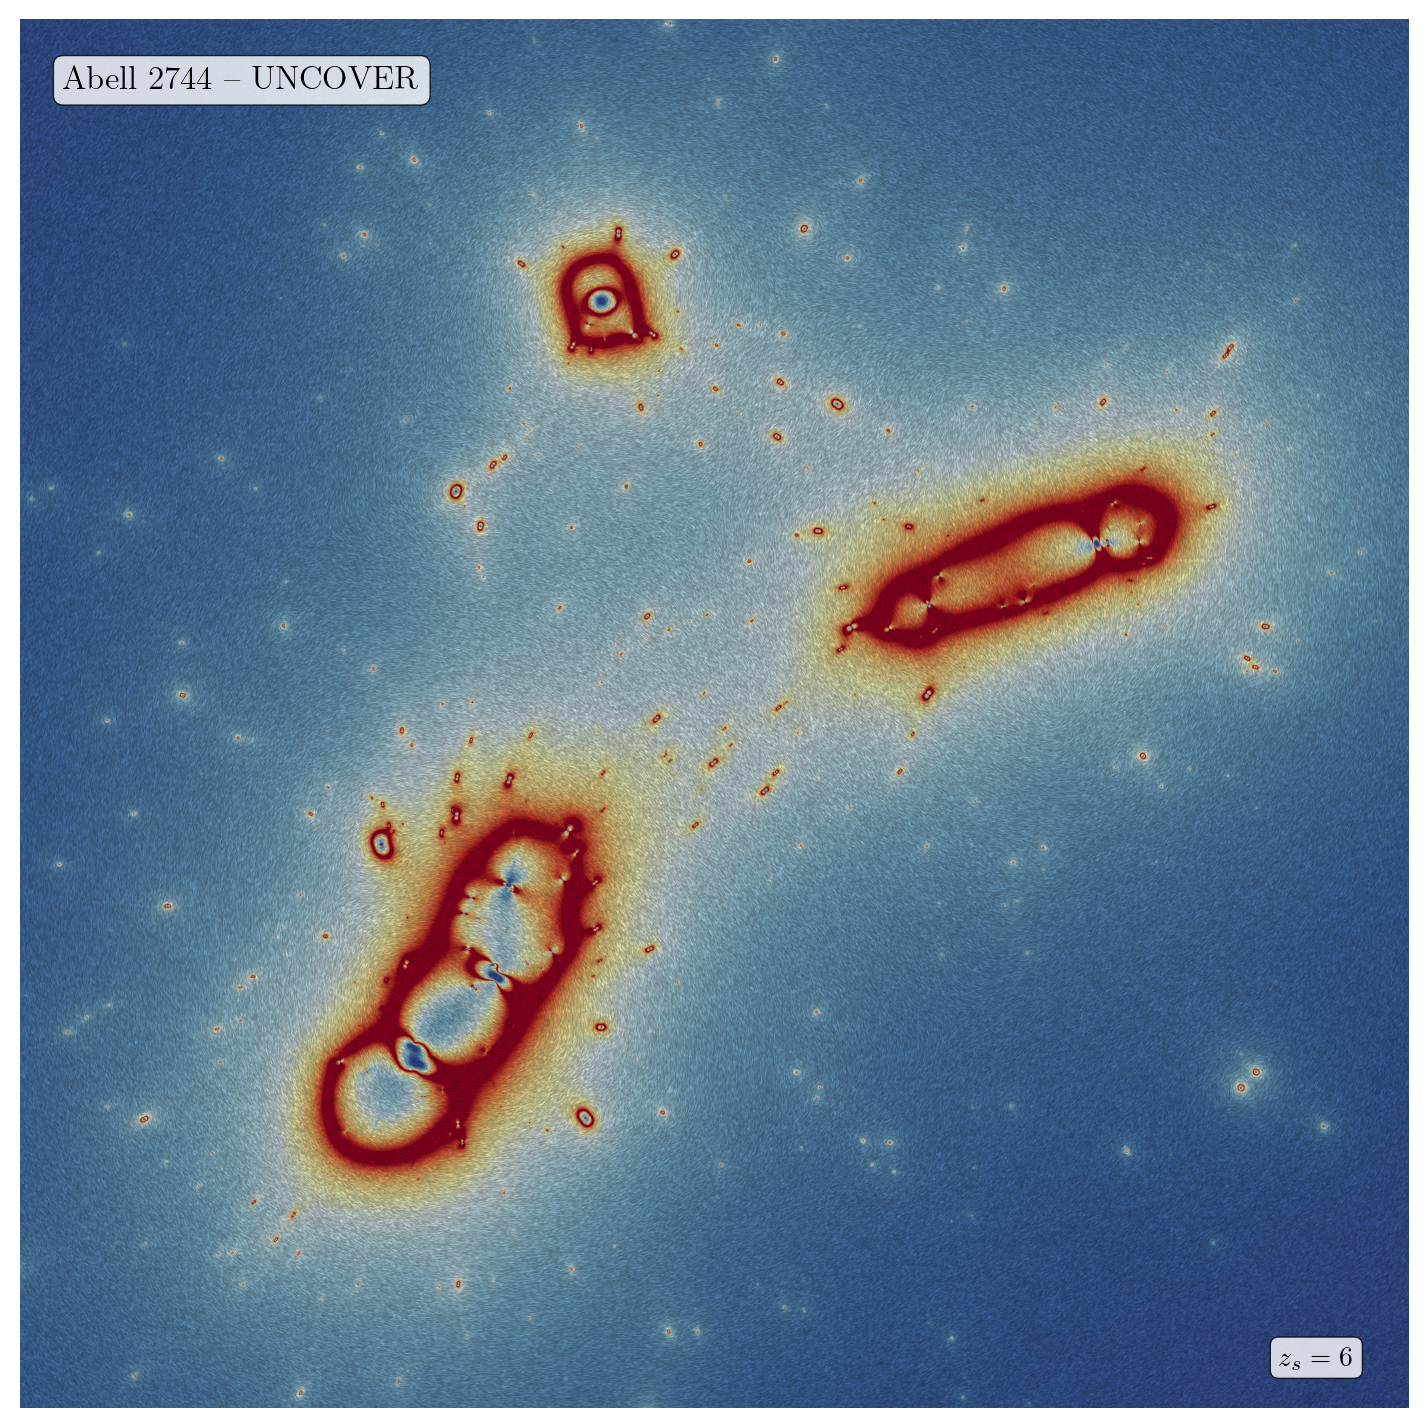

In [31]:
# Define logarithmic clipping (--> following Dan)
def log10clip(x, loexp, hiexp):
    return np.log10(np.clip(x, 10.**loexp, 10.**hiexp))

# Define zero-padding (--> following Dan)
def zeropad(a, n=1, val=0):
    ny, nx = a.shape
    bny = ny + 2 * n
    bnx = nx + 2 * n
    dtype = type(a[0,0])
    b = np.zeros((bny, bnx), dtype=dtype) + val
    b[n:-n,n:-n] = a
    return b

# Prepare the lic (--> from Dan, but needed to customize values)
#kfac = 1/30.
#mid = kernellen / 2.
#lo = (1-kfac) * mid
#hi = (1+kfac) * mid
#lo = 8
#hi = 12
lo = 9.5
hi = 11.5
shear_lic_p = np.clip(shear_lic, lo, hi)
shear_lic_p = (shear_lic_p - lo) / float(hi - lo)
shear_lic_p = 0.42 * shear_lic_p + 0.58
#shear_lic_p = zeropad(shear_lic_p)

# Clip the magnification map (--> following Dan)
#loexp, hiexp = 0, 2
loexp, hiexp = 0.1, 1.5
mu_p = log10clip(mu, loexp, hiexp)
mu_p = (mu_p - loexp) / float(hiexp - loexp)
mu_p = 0.95 * mu_p + 0.05
mu_p = 1 - mu_p

# Make the RGBA object to plot (--> following Dan)
rgba = cm.RdYlBu(mu_p)
rgba = rgba * shear_lic_p[:,:,np.newaxis]
rgba[:,:,-1] = 1
rgba = 255 * rgba
rgba = rgba.astype(np.uint8)

# Configure figure
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, subplot_kw={'projection': altlenswcs}, figsize=(5., 5.))

# Manipulate axes
ax.axis('off')

# Plot magnification map
im = ax.imshow(rgba, origin='lower')

# Plot cluster name
ax.text(6100-8000/2+250, 5200+8000/2-400, 'Abell 2744 -- UNCOVER',
        bbox={'edgecolor': 'k', 'facecolor': 'w', 'lw': 0.5, 'boxstyle': 'Round', 'alpha': 0.8},
        fontsize=12)

# Plot the source redshift
ax.text(6100+8000/2-750, 5200-8000/2+250, '$z_s='+str(zs)+'$',
        bbox={'edgecolor': 'k', 'facecolor': 'w', 'lw': 0.5, 'boxstyle': 'Round', 'alpha': 0.8},
        fontsize=10)

# Configure plot
ax.coords['ra'].set_axislabel('RA', minpad=0.6, fontsize=10)
ax.coords['dec'].set_axislabel('Dec.', minpad=-1., fontsize=10)

ax.coords['ra'].display_minor_ticks(True)
ax.coords['dec'].display_minor_ticks(True)

# Crop the plot
ax.set_xlim(6100-8000/2, 6100+8000/2)
ax.set_ylim(5200-8000/2, 5200+8000/2)

# Save the figure
fig.savefig('A2744_lensing_flow_v2.0.pdf', dpi=1000, format='pdf', bbox_inches='tight', pad_inches=0)
#fig.savefig('A2744_lensing_grid_flow_v2.0.pdf', dpi=1000, format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# Close the figure
plt.close(fig)